# Data Preparation and Model Training

In this notebook, we load the [Iris plants dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris), extract features, and train a Random Forest classifier.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import mlflow
from sklearn import datasets
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


C:\Users\cjy12\AppData\Local\Temp\ipykernel_19148\979361594.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


## Data Preparation

We use the [Iris plants dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris) to predict the class of Iris flowers.
It contains 150 samples (50 for each instance), and the following 4 numeric, predictive attributes.

- sepal length in cm
- sepal width in cm
- petal length in cm
- petal width in cm

The class names are Iris-Setosa (`0`), Iris-Versicolour (`1`), and Iris-Virginica (`2`).


In [2]:
import os
homedir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [3]:
berlin_gpd = gpd.read_file(homedir+"\\frontend\crime_pp_cafes.gpkg")
X = berlin_gpd[["Robbery", "bp_weight","restaurant"]].to_numpy()
y = berlin_gpd["Land_Value"].to_numpy()

In [8]:
X.shape, y.shape

((96, 3), (96,))

In [2]:
X, y = datasets.load_iris(return_X_y=True)
X.shape, y.shape


((150, 4), (150,))

'c:\\Users\\cjy12\\source\\repos\\final_exercise\\solution'

In [3]:
X.min(axis=0), X.max(axis=0)


(array([4.3, 2. , 1. , 0.1]), array([7.9, 4.4, 6.9, 2.5]))

In [4]:
col_mean = np.nanmean(X, axis=0)

In [5]:
inds = np.where(np.isnan(X))
X[inds] = np.take(col_mean, inds[1])

Let's plot the data to gain some insights.


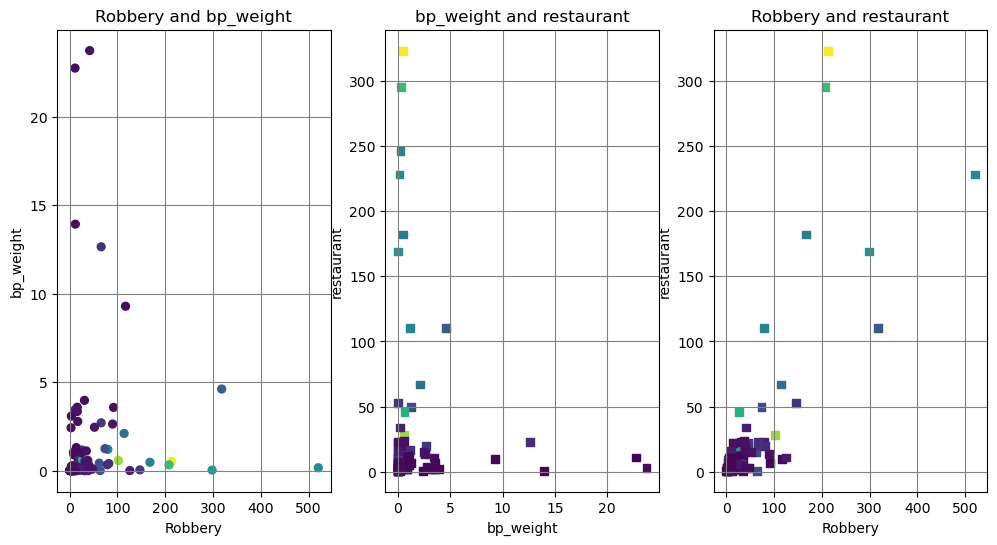

In [12]:
fig = plt.figure(figsize=(12, 6))

# Petal Length and Width
ax = fig.add_subplot(131)
ax.set_title('Robbery and bp_weight')
ax.set_xlabel('Robbery')
ax.set_ylabel('bp_weight')
ax.grid(True, linestyle='-', color='0.5')
ax.scatter(X[:, 0], X[:, 1], s=32, c=y, marker='o')

# Sepal Length and Width
ax = fig.add_subplot(132)
ax.set_title("bp_weight and restaurant")
ax.set_xlabel('bp_weight')
ax.set_ylabel('restaurant')
ax.grid(True, linestyle='-', color='0.5')
ax.scatter(X[:, 1], X[:, 2], s=32, c=y, marker='s')

# Sepal Length and Width
ax = fig.add_subplot(133)
ax.set_title("Robbery and restaurant")
ax.set_xlabel('Robbery')
ax.set_ylabel('restaurant')
ax.grid(True, linestyle='-', color='0.5')
ax.scatter(X[:, 0], X[:, 2], s=32, c=y, marker='s')


**Task:** Split the data into train and test sets. Use $60%$ samples for training.


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42)
X_train.shape, X_test.shape


((57, 3), (39, 3))

In [ ]:
col_mean = np.nanmean(X, axis=0)

## ML Training

### Model Training and Logging

Let's use random forest regression to predict house prices.
Therefore, we want to find a reasonable maximum depth for the single decision trees.
We keep track of several tries and their mean squared error using MLflow.

Please note that we ignore best practices like cross validation, feature selection and randomised parameter search for demonstration purposes.

**Task:** Setup the pipeline factory with a random forest classifier using `max_depth=3` and a specified number of estimators. You might add additional pipeline steps.


In [7]:
def create_pipeline(n_estimators: int) -> Pipeline:
    return Pipeline(
        steps=[('scalar', StandardScaler()),
               ('model', KernelRidge(alpha=1.0))])


**Task:** Choose reasonable hyperparameters to try, and execute the training process. Log the accuracy and according parameters. You might add further metrics.


In [8]:
n_alphas_to_try = [0.5, 1, 1.5]
REGISTERED_MODEL_NAME = "krr"

for alpha in n_alphas_to_try:
    with mlflow.start_run():
        # build a pipeline with a ridge regression model
        model_pipeline = create_pipeline(n_estimators=alpha)
        model_pipeline.fit(X_train, y_train)

        # calculaye metrics using the test data
        y_pred = model_pipeline.predict(X=X_test)
        r2 = r2_score(y_true=y_test, y_pred=y_pred)

        # log parameters, metrics and the model
        mlflow.log_param(key="alpha", value=alpha)
        mlflow.log_metric(key="R2", value=r2)
        mlflow.sklearn.log_model(
            sk_model=model_pipeline, artifact_path="dlr", registered_model_name=REGISTERED_MODEL_NAME)

        print(
            f"Model saved in run {mlflow.active_run().info.run_uuid}. R2={r2}")


c:\Users\cjy12\miniconda3\envs\ifohack_spatial_py310\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'krr' already exists. Creating a new version of this model...
2023/04/30 09:07:17 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: krr, version 4
Created version '4' of model 'krr'.


Model saved in run c8740ead47a74fbd89a182a32a527aad. R2=-0.022403541121678305


Registered model 'krr' already exists. Creating a new version of this model...
2023/04/30 09:07:27 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: krr, version 5
Created version '5' of model 'krr'.


Model saved in run c2df8d8a2c9c422bbd3c06e626840c45. R2=-0.022403541121678305


Registered model 'krr' already exists. Creating a new version of this model...
2023/04/30 09:07:37 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: krr, version 6


Model saved in run 4bf6e3603f3c4d2d9af49684d20dfa66. R2=-0.022403541121678305


Created version '6' of model 'krr'.


### Assessing the Runs in the MLflow Web-UI

**Task:** Inspect the training runs with their parameters and metrics with MLflow's web-UI.
Store the best model in the model registry, and stage it for production (either in the web UI, or using the Python interface).

Just execute this cell and visit the uri in your web browser.
Terminate this cell or the notebook to stop the server.


In [9]:
!mlflow ui -p 5002


^C


In [9]:
client = mlflow.MlflowClient()
client.transition_model_version_stage(
    name=REGISTERED_MODEL_NAME, version=3, stage="Production"
)


<ModelVersion: aliases=[], creation_timestamp=1682836626628, current_stage='Production', description=None, last_updated_timestamp=1682838457924, name='krr', run_id='8963a98f13514caab53f5d884119ebde', run_link=None, source='file:///c:/Users/cjy12/source/repos/final_exercise/solution/model_api/mlruns/0/8963a98f13514caab53f5d884119ebde/artifacts/dlr', status='READY', status_message=None, tags={}, user_id=None, version=3>

## Model Deployment

Let's use our production model to generate a Docker image for the model endpoint.

Please note that the first run of this cell might take some minutes.
In the meantime, you can start with the next tasks.


In [10]:
mlflow.models.build_docker(
    model_uri=f"models:/{REGISTERED_MODEL_NAME}/Production", name="iris_model_api", env_manager="conda", install_mlflow=True)

2023/04/30 09:07:39 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
2023/04/30 09:07:39 INFO mlflow.models.docker_utils: Building docker image with name iris_model_api
#1 [internal] load build definition from Dockerfile
#1 sha256:196176d9db7f33bf4e20e044ec9bffdc4fa9385d399166aa562bcd7b87e9c854
#1 transferring dockerfile: 2.14kB 0.1s done
#1 DONE 0.1s

#2 [internal] load .dockerignore
#2 sha256:ef2f4d602852de4472b74a2d559cbecaeaf94f8357d36423472c0304845b3026
#2 transferring context: 2B done
#2 DONE 0.0s

#3 [internal] load metadata for docker.io/library/ubuntu:20.04
#3 sha256:8e67b796a66f85f06793e026943184e32d365c77929e94d2ac98b34a1e1cb30e
#3 DONE 4.0s

#4 [ 1/14] FROM docker.io/library/ubuntu:20.04@sha256:db8bf6f4fb351aa7a26e27ba2686cf35a6a409f65603e59d4c203e58387dc6b3
#4 sha256:1bae5227e407d99860558d8d8b17e917f6c8055fb0b00be1395da7669a1fe74d
#4 DONE 0.0s

#6 [ 3/14] RUN DEBIAN_FRONTEND=noninteractive TZ=Etc/UTC apt-get install -y --no-install-